# Ocular Disease Recognition

#### Furkan Çakar

In this notebook, I am aiming to predict cataract disease from fluorescein eye angiography images. My data set contains 3411 image. For predicting, I aim to succesfully classify images with Keras's Convolutional Neural Network.

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>


* Poor countries have shortage of ophthalmologist. For instance in Turkey, people can not find doctor appointments for months. 
Most of the times, detecting the eye disease requires little effort and equipment. 
* On the other hand, vision is one of the most critical ability for humans. Affects daily performance, life quality and even occupations.
This project aims to design a machine learning model for detecting if an eye has cataract or not. And prevent one of the most significant cause of blindness.
* Fluorescein eye angiography devices are cheap, easy to use. With Machine Learning Model, family doctors can diagnose most critical eye diseases.


## Data Understanding<a class="anchor" id="data_understanding"></a>

* Dataset contains 7000 fluorescein eye angiography images in various resolutions.
* There are 7 classes, but increasing class number that high resulted low accuracy.
* So I choose cataract, which is very common and dangerous disease.

## Data Preparation<a class="anchor" id="data_preparation"></a>

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "" 
os.environ['KAGGLE_KEY'] = "" 
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

100% 1.62G/1.62G [00:13<00:00, 91.9MB/s]



In [2]:
!unzip -q ocular-disease-recognition-odir5k.zip
!rm -r preprocessed_images/

Dataset is not splitted by categories. We are going to select images by reading an index file.


In [3]:
import pandas as pd
import os
df = pd.read_excel('ODIR-5K/ODIR-5K/data.xlsx')
df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


* Last rows indicates the diseases, but it does not indicates which eye does have that disease. So I searched Diagnostic Keywords column.

In [4]:
!mkdir train
!mkdir test
!mkdir train/cataract
!mkdir train/normal
!mkdir test/cataract
!mkdir test/normal

* In the data frame, *Left-Diagnostic Keyword* and *Right-Diagnostic Keyword* columns contains diseases determined by ophthalmologist.
* Firstly, I searched the keywords in the columns for diagnosis. 
* Then moved diagnosed files to appropriate folder structure.
* For splitting training and testing, I am creating random integers between 0 and 9. Test size is %30.

In [5]:
from os import path
from shutil import copy
import random

for i in range(len(df)):
  splitting = random.randint(0,9)
  if "normal fundus" in df.iloc[i]["Right-Diagnostic Keywords"]:
    source = "ODIR-5K/ODIR-5K/Training Images/"+df.iloc[i]["Right-Fundus"]
    if splitting > 2:
      copy(source, "./train/normal")
    else:
      copy(source, "./test/normal")
  if "normal fundus" in df.iloc[i]["Left-Diagnostic Keywords"]:
    source = "ODIR-5K/ODIR-5K/Training Images/"+df.iloc[i]["Left-Fundus"]
    if splitting > 2:
      copy(source, "./train/normal")
    else:
      copy(source, "./test/normal")

  if "cataract" in df.iloc[i]["Right-Diagnostic Keywords"]:
    source = "ODIR-5K/ODIR-5K/Training Images/"+df.iloc[i]["Right-Fundus"]
    if splitting > 2:
      copy(source, "./train/cataract")
    else:
      copy(source, "./test/cataract")
  if "cataract" in df.iloc[i]["Left-Diagnostic Keywords"]:
    source = "ODIR-5K/ODIR-5K/Training Images/"+df.iloc[i]["Left-Fundus"]
    if splitting > 2:
      copy(source, "./train/cataract")
    else:
      copy(source, "./test/cataract")


* Keras has useful ImageDataGenerator feature. This helps us to generate batches of data, with real time data augmentation.
* Data Augmentation is a process to prevent overfitting issue. 
* With data augmentation, we flip, rotate, shear, scale crop the image and create larger dataset for training. 
* Size of cataract images are relatively small. 
* Shear, scale and crop operations are not suitable for medical examination of eye.
* We are applying rotation operation.
* Also rescaling the color values.

In [6]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_generator = ImageDataGenerator(rescale=1/255, rotation_range = 90)
train_dataset = train_generator.flow_from_directory("./train", target_size = (150, 150), batch_size = 16, class_mode = 'binary')

Found 2391 images belonging to 2 classes.


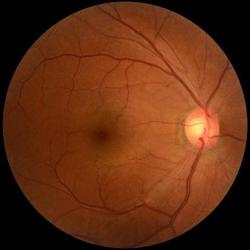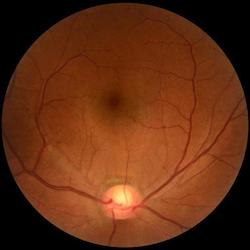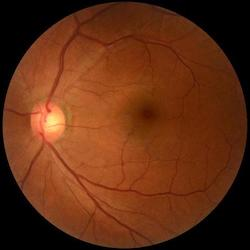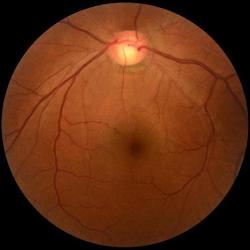


In [8]:
test_generator = ImageDataGenerator(rescale=1/255)
test_dataset = test_generator.flow_from_directory("./test", target_size=(150, 150), batch_size = 16, class_mode = "binary")

Found 1020 images belonging to 2 classes.


* Data augmentation is not necessary for test dataset.
* Both images' resolutions are set to 150x150.

## Modeling<a class="anchor" id="modeling"></a>

* I am using Keras Sequential
* Sequential model is basically linear stack of layers.
* I chosed 3 convolutional layers and max pool layers.


##### Convolutional Layer

* In convolutional layer, filters are applied.
* After filtering, generated datas are passing to the next level of CNN model.
* Features are extracted by filtering.
* Input size is specified in first layer. (150 x 150)

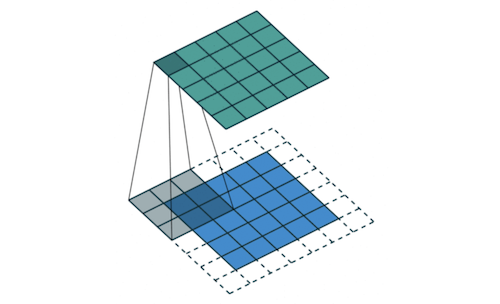

##### Pooling Layer
* Pooling extract information and reduce dimensionality.
* There are different methods like average pooling, global pooling.
* This model detect the most significant value in the area.
* Called Max Pooling.
* Looks at 2x2 area, and selects the maximum.

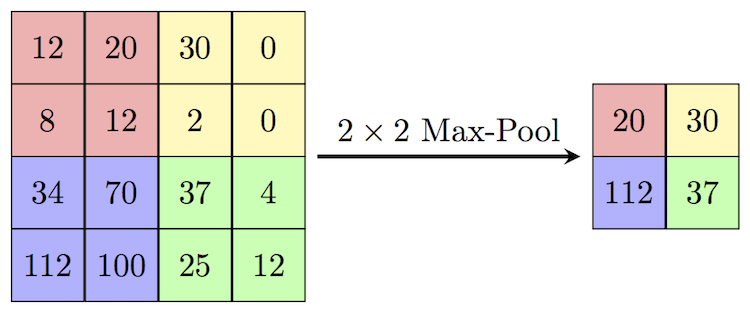

* Convolutional layers will be used with 32, 64 and 128 filters.

In [9]:
model = keras.Sequential([
        keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
        keras.layers.MaxPool2D(2,2),

        keras.layers.Conv2D(64,(3,3),activation='relu'),
        keras.layers.MaxPool2D(2,2),

        keras.layers.Conv2D(128,(3,3),activation='relu'),
        keras.layers.MaxPool2D(2,2),

        keras.layers.Flatten(),
        keras.layers.Dense(1,activation='sigmoid')
])

In [10]:
from keras.optimizers import SGD
model.compile(optimizer= SGD(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
model.fit_generator(train_dataset, validation_data = test_dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


150/150 [==============================] - 283s 2s/step - loss: 0.3816 - accuracy: 0.8831 - val_loss: 0.3288 - val_accuracy: 0.9029


## Evaluation<a class="anchor" id="evaluation"></a>

* Because of an underlying problem, **increasing epochs didn't increase the accuracy scores.** I couldn't find the problem behind it, but probably it is because of small dataset.
* If we consider my goal on this project, *helping family doctors to diagnose and divert to opthalmologist,* %90 validation accuracy is satisfactory.
* When I run model for multiple classes, accuracy score was about %65.
* Data augmentation options were limited. For example, we couldn't apply streching, because it would cause false learning from myopia, which is streching of eyeball.

## References<a class="anchor" id="references"></a>

Articles from: www.towardsdatascience.com 


Dataset: https://www.kaggle.com/andrewmvd/ocular-disease-recognition-odir5k





**Disclaimer!** <font color='grey'>This notebook was prepared by Furkan Çakar as a term project for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>